<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost-без-GridSearch" data-toc-modified-id="CatBoost-без-GridSearch-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost без GridSearch</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Цель исследования** - выполнить следующие задачи:

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pymystem3 import Mystem
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#прочитаем файл
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
#выведем первые 5 строк таблицы
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
#выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
#проверим колличество пропусков в %
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Unnamed: 0,0.000000
text,0.000000
toxic,0.000000


In [6]:
#посмотрим на количество дубликатов
data.duplicated().sum()

0

Видим некий столбец Unnamed, он просто даёт номер каждому тексту. Он не несёт никакой ценности для обучения моделей, а значит удалим его. 

In [7]:
data = data.drop('Unnamed: 0', axis=1)

In [8]:
#посмотрим на количество токсичных комментариев
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

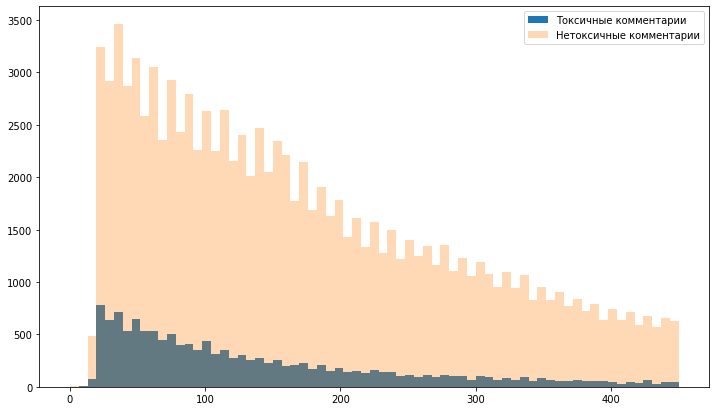

In [9]:
#посмотрим на длину токсичных и обычных предложений
toxic = data[data['toxic'] == 1]['text'].apply(lambda x: len(x) - len(' '))
non_toxic = data[data['toxic'] == 0]['text'].apply(lambda x: len(x) - len(' '))
bins1 = np.linspace(0, 450, 70)
plt.figure(figsize=(12, 7))
plt.hist(toxic, bins=bins1, alpha = 1, label = 'Токсичные комментарии')
plt.hist(non_toxic, bins=bins1, alpha = 0.3, label = 'Нетоксичные комментарии')
plt.legend()
plt.show()

Обратим внимание, что длина нормальных комментариев больше, нежели токсичных

Выполним лемматизацию текста

In [10]:
import spacy

sp = spacy.load('en_core_web_sm')
def lemmatize(text):    
    clear_text = ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split())
    doc = sp(clear_text)
    lemm_text = ' '.join([word.lemma_ for word in doc])
    return lemm_text


data['lemm_text'] = data['text'].progress_apply(lemmatize)
data.head(5)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Подготовим признаки и разобьём данные на выборки

In [11]:
features = data.drop('toxic', axis=1)
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.9, random_state=42)


#подготовим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

#создадим счётчик
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)

#переведём выборки в стандартный для Python формат
#features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
#features_test = count_tf_idf.transform(features_test['lemm_text'])

#display(features_train.shape, features_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Вывод**

При подготовке данных мы выполнили следующее:

* удалили признак, который никак не повлияет на обучение модели
* выяснили, что дубликаты и пропуски отсутствуют
* узнали длину токсичных и обычных комментариев
* выполнили лемматизацию текста
* подготовили выборки и стоп-слова

Можно приступать к обучению моделей

## Обучение

Использовать будем следующие модели:
* Логистическя регрессия
* Дерево решений
* LightGBM
* Catboost

### Логистическая регрессия

In [12]:
pipe = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('lr', LogisticRegression())])
hyperparams = [{'lr__solver' : ['liblinear'],
                'lr__class_weight' : ['balanced', None],
                'lr__C' : [1, 10, 20]}]

grid_scv = GridSearchCV(pipe, hyperparams, cv=3, scoring='f1')
grid_scv.fit(features_train['lemm_text'], target_train)
log_best_params = grid_scv.best_params_

print(grid_scv.best_estimator_)
print(log_best_params)
print('F1-мера:', grid_scv.best_score_)

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('lr', LogisticRegression(C=20, solver='liblinear'))])
{'lr__C': 20, 'lr__class_weight': None, 'lr__solver': 'liblinear'}
F1-мера: 0.775511316457215


### Дерево решений

In [13]:
pipe = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('tr', DecisionTreeClassifier())])
hyperparams = [{'tr__max_depth' : [10, 20, 30],
                'tr__class_weight' : ['balanced', None],
                'tr__random_state' : [42]}]

grid_tree = GridSearchCV(pipe, hyperparams, cv=3, scoring='f1')
grid_tree.fit(features_train['lemm_text'], target_train)
tree_best_params = grid_tree.best_params_

print(grid_tree.best_estimator_)
print(tree_best_params)
print('F1-мера:', grid_tree.best_score_)

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tr', DecisionTreeClassifier(max_depth=30, random_state=42))])
{'tr__class_weight': None, 'tr__max_depth': 30, 'tr__random_state': 42}
F1-мера: 0.6867532160023684


### LightGBM

In [18]:
pipe = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('lgbm', LGBMClassifier())])
hyperparams = [{'lgbm__boosting_type' : ['gbdt'],
                'lgbm__num_leaves' : [10, 31, 50], 
                'lgbm__learning_rate' : [0.05, 0.1, 0.2],
                'lgbm__class_weight' : ['balanced', None]}]

grid_lgbm = GridSearchCV(pipe, hyperparams, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid_lgbm.fit(features_train['lemm_text'], target_train)
lgbm_best_params = grid_lgbm.best_params_

print(grid_lgbm.best_estimator_)
print(lgbm_best_params)
print('F1-мера:', grid_lgbm.best_score_)

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('lgbm', LGBMClassifier(learning_rate=0.2, num_leaves=50))])
{'lgbm__boosting_type': 'gbdt', 'lgbm__class_weight': None, 'lgbm__learning_rate': 0.2, 'lgbm__num_leaves': 50}
F1-мера: 0.7734541975787046


### CatBoost без GridSearch

In [16]:
pipe = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), 
                 ('cat', CatBoostClassifier(verbose=0, iterations=150))])
cat_cv = cross_val_score(pipe, 
                         features_train['lemm_text'], 
                         target_train,
                         cv=3,
                         scoring='f1')
val_score = cat_cv.mean()
print('F1:', val_score)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1: 0.7484363576278487


**Вывод**

Обучив модели мы выяснили:
* модель LightGBM показала значение F1-меры = 0.77, но скорость выполнения слишком медленная
* логистическая регрессия тоже показала значение F1-меры = 0.77, но скорость выполнения гораздо выше
* CatBoost с F1-мерой = 0.748 очень близко к пороговому значению в 0.75. Я уверен, что можно спокойно поднять выше, если подбирать гиперпараметры
* дерево решений явный аутсайдер
* поскольку 2 модели имеют F1-меру выше пороговой, то на них и проведём тестирование

## Тестирование

Для более подробного результата мы вычислим accuracy, precision, recall, f1-меру, ROC-AUC и построим график

AUC-ROC модели LightGBM на тестовой выборке: 0.9700943616787276
Accuracy модели LightGBM на тестовой выборке: 0.9610169491525423
Precision модели LightGBM на тестовой выборке: 0.8806426931905126
Recall модели LightGBM на тестовой выборке: 0.7122524752475248
F-мера модели LightGBM на тестовой выборке: 0.7875470407115978

AUC-ROC модели логистической регрессии на тестовой выборке: 0.9695750680978396
Accuracy модели логистической регрессии на тестовой выборке: 0.9614563716258632
Precision модели логистической регрессии на тестовой выборке: 0.8806990881458967
Recall модели логистической регрессии на тестовой выборке: 0.7172029702970297
F-мера модели логистической регрессии на тестовой выборке: 0.7905866302864939


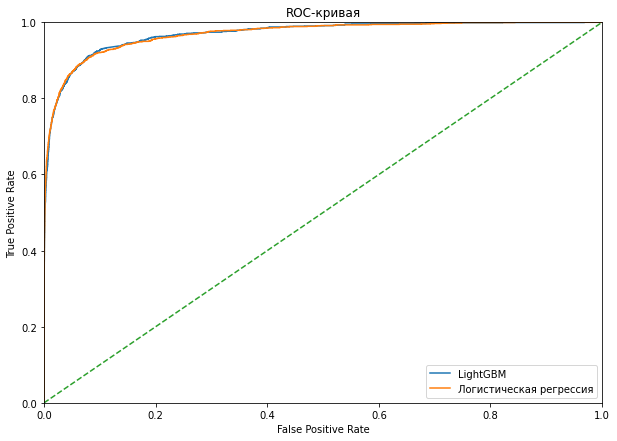

In [20]:
plt.figure(figsize=(10, 7))

best_model_lgbm = grid_lgbm.best_estimator_
predictions = best_model_lgbm.predict(features_test['lemm_text'])

probabilities_valid = best_model_lgbm.predict_proba(features_test['lemm_text'])
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC модели LightGBM на тестовой выборке:', auc_roc)
print('Accuracy модели LightGBM на тестовой выборке:', accuracy_score(target_test, predictions))
print('Precision модели LightGBM на тестовой выборке:', precision_score(target_test, predictions))
print('Recall модели LightGBM на тестовой выборке:', recall_score(target_test, predictions))
print('F-мера модели LightGBM на тестовой выборке:', f1_score(target_test, predictions))
print()
plt.plot(fpr, tpr, label='LightGBM')

best_model_log = grid_scv.best_estimator_
predictions = best_model_log.predict(features_test['lemm_text'])

probabilities_valid = best_model_log.predict_proba(features_test['lemm_text'])
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC модели логистической регрессии на тестовой выборке:', auc_roc)
print('Accuracy модели логистической регрессии на тестовой выборке:', accuracy_score(target_test, predictions))
print('Precision модели логистической регрессии на тестовой выборке:', precision_score(target_test, predictions))
print('Recall модели логистической регрессии на тестовой выборке:', recall_score(target_test, predictions))
print('F-мера модели логистической регрессии на тестовой выборке:', f1_score(target_test, predictions))
plt.plot(fpr, tpr, label='Логистическая регрессия')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC-кривая')
plt.show()

**Вывод**

Можно смело сказать, что модели справились с задачей. 

* LightGBM выдал F1-меру на тестовой выборке = 0.78 
* Логистическая регрессия на тестовой выборке = 0.79
* Высокий показатель accuracy и precision говорит нам о том, что модели вполне хорошо находит токсичные комментарии.

## Общий вывод

В ходе работы мы:

1. Изучили данные интернет-магазин «Викишоп»
2. Просмотрели данные на пропуски и дубликаты
3. Изучили длину обычных и токсичных комментариев
4. Провели лемматизацию текста
5. Подготовили данные и разбили на выборки
6. Обучили модели
7. Провели тестирование на лучших моделях

LightGBM и логистическая регрессия оказались лучшими моделями.  Модели хорошо находит токсичные комментарии, ибо их показатели accuracy и precision довольно высоки. 

F1-мера LightGBM с кросс-валидацией = 0.77, а на тестовой выборке = 0.78. Скорость выполнения модели очень медленная.

F1-мера логистической регрессии с кросс-валидацией = 0.77, а на тестовой выборке = 0.79. Скорость выполнения быстрая.

**Можно дать такие рекомендации:**
* Если скорость выполнения не важна, то можно остановиться на LightGBM
* Если скорость выполнения важна, то выбор падает на логистическую регрессию